# Installing Requirements

In [1]:
!pip install -q transformers

     |████████████████████████████████| 4.4 MB 28.4 MB/s 
     |████████████████████████████████| 6.6 MB 54.2 MB/s 
     |████████████████████████████████| 596 kB 38.5 MB/s 
     |████████████████████████████████| 101 kB 9.8 MB/s 


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments

# Connecting to Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# Hyperparameters

In [4]:
MAX_LEN = 64
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 32
LEARNING_RATE = 1e-05
NUM_CLASSES = 6
EPOCHS = 10

# Processing data

## Creating a dataframe

In [5]:
df = pd.read_csv("/content/gdrive/MyDrive/Homeworks/NLP/Project/Phase2/dialogues_cleaned.csv")
df = df.drop(df[df["person"]=="person"].index)

## Label Encoder

In [6]:
le = preprocessing.LabelEncoder()
LABELS = ["chandler", "monica", "rachel", "phoebe", "joey", "ross"]
le.fit(LABELS)

LabelEncoder()

In [7]:
x = df["dialogue"]
y = df["person"]
y = le.transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [8]:
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (7104,)
y_train: (7104,)
x_test: (1776,)
y_test: (1776,)


## DistilBERT Tokenizer

In [9]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

x_train_tokenized = tokenizer(x_train.tolist(), padding=True, truncation=True, max_length=MAX_LEN)
x_test_tokenized = tokenizer(x_test.tolist(), padding=True, truncation=True, max_length=MAX_LEN)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Data loaders

In [10]:
class Dataset(torch.utils.data.Dataset):    
    def __init__(self, x, y=None):          
        self.x = x
        self.y = torch.tensor(y)
     
    def __getitem__(self, idx):
        item = {key:torch.tensor(val[idx]) for key, val in self.x.items()}
        if self.y is not None:
            item["labels"] = self.y[idx]
        return item
        
    def __len__(self):
        return len(self.x["input_ids"])


train_dataset = Dataset(x_train_tokenized, y_train)
test_dataset = Dataset(x_test_tokenized, y_test)

# Model

In [11]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=NUM_CLASSES
)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [12]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=-1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average="weighted")
    precision = precision_score(y_true=labels, y_pred=pred, average="weighted")
    f1 = f1_score(y_true=labels, y_pred=pred, average="weighted")
    return {"Accuracy": accuracy, "Precision": precision, "F1": f1} 

# Train

In [13]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    report_to="all",
    logging_steps=1,
)

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [15]:
best = trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7104
  Num Epochs = 10
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1110


Epoch,Training Loss,Validation Loss,Accuracy,Precision,F1
1,1.763900,1.692776,0.295608,0.362175,0.268334
2,1.521100,1.407373,0.469032,0.478789,0.461560
3,1.049900,1.080330,0.626689,0.634673,0.623860
4,0.642700,0.866115,0.717342,0.727719,0.718102
5,0.407900,0.775580,0.770270,0.779488,0.770904
6,0.298500,0.744298,0.786599,0.795118,0.787742
7,0.239000,0.735202,0.796171,0.798505,0.796475
8,0.207800,0.743849,0.801239,0.803646,0.801275
9,0.187500,0.748156,0.806306,0.809379,0.806430
10,0.172500,0.733611,0.807995,0.809453,0.807956


***** Running Evaluation *****
  Num examples = 1776
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1776
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1776
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1776
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1776
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1776
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1776
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1776
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1776
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
**

In [16]:
model.save_pretrained("/content/gdrive/MyDrive/Homeworks/NLP/Project/Phase2/Models/transformer_model")

Configuration saved in /content/gdrive/MyDrive/Homeworks/NLP/Project/Phase2/Models/transformer_model/config.json
Model weights saved in /content/gdrive/MyDrive/Homeworks/NLP/Project/Phase2/Models/transformer_model/pytorch_model.bin


# Results

In [17]:
def get_reports(y_true, y_pred, mode, labels=LABELS):
    cr = classification_report(y_true, y_pred, target_names=labels)
    cm = confusion_matrix(y_true, y_pred)

    print(f'\nClassification Report {mode}')
    print(cr)

    print(f'Confusion Matrix {mode}')
    print(cm)

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest')
    plt.colorbar()
    tick_mark = np.arange(len(labels))
    _ = plt.xticks(tick_mark, labels, rotation=90)
    _ = plt.yticks(tick_mark, labels)

In [18]:
tr_preds = trainer.predict(train_dataset)[0].argmax(1)
val_preds = trainer.predict(test_dataset)[0].argmax(1)

***** Running Prediction *****
  Num examples = 7104
  Batch size = 32


***** Running Prediction *****
  Num examples = 1776
  Batch size = 32


In [19]:
tr_trues = []
for idx, data in enumerate(train_dataset):
    label = data["labels"].item()
    tr_trues.append(label)


Classification Report Train
              precision    recall  f1-score   support

    chandler       0.99      0.94      0.96      1256
      monica       0.90      0.94      0.92      1107
      rachel       0.94      0.94      0.94      1217
      phoebe       0.97      0.93      0.95      1042
        joey       0.90      0.96      0.93      1226
        ross       0.96      0.93      0.95      1256

    accuracy                           0.94      7104
   macro avg       0.94      0.94      0.94      7104
weighted avg       0.94      0.94      0.94      7104

Confusion Matrix Train
[[1176   25   14    6   22   13]
 [   4 1046   10    3   33   11]
 [   4   21 1148   10   23   11]
 [   3   23   11  971   28    6]
 [   1   19   20    5 1173    8]
 [   5   31   16   11   24 1169]]


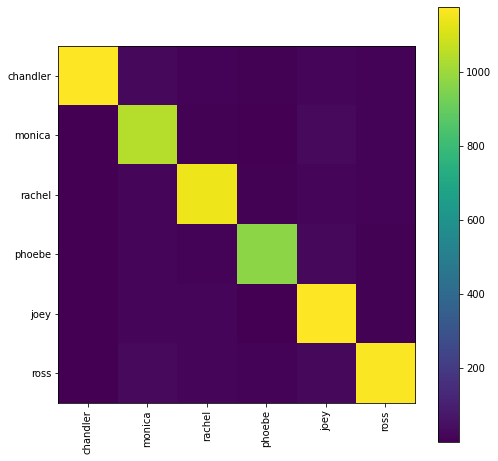

In [20]:
get_reports(tr_trues, tr_preds, mode="Train")

In [21]:
val_trues = []
for idx, data in enumerate(test_dataset):
    label = data["labels"].item()
    val_trues.append(label)


Classification Report Validation
              precision    recall  f1-score   support

    chandler       0.82      0.80      0.81       322
      monica       0.80      0.81      0.80       275
      rachel       0.82      0.83      0.82       305
      phoebe       0.83      0.78      0.81       260
        joey       0.77      0.86      0.81       312
        ross       0.83      0.78      0.80       302

    accuracy                           0.81      1776
   macro avg       0.81      0.81      0.81      1776
weighted avg       0.81      0.81      0.81      1776

Confusion Matrix Validation
[[256  11  18  12  16   9]
 [ 12 222   8   3  19  11]
 [ 10   7 252   4  21  11]
 [ 11  13  11 203  12  10]
 [  9   7  10  13 267   6]
 [ 15  19  10   9  14 235]]


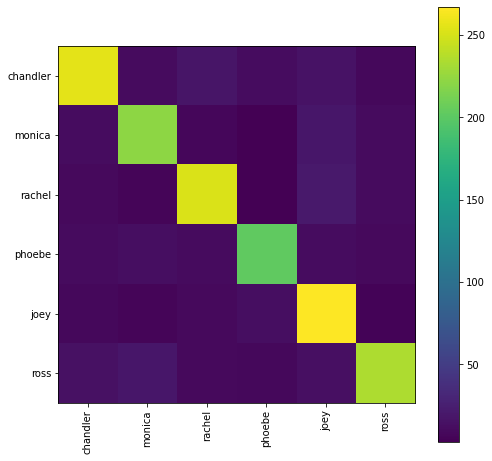

In [22]:
get_reports(val_trues, val_preds, mode="Validation")